### Explore meteorological data

In [68]:
import os
import zipfile
import pandas as pd
import glob
import keplergl
import geopandas as gpd
import matplotlib.pyplot as plt
import csv
from datetime import datetime

In [ ]:
# Drive folder with original data: https://drive.google.com/drive/folders/1me2IpDY3om6IRKv_WMT5W6Qw0r9DI74C

In [4]:
os.listdir('data')

['.DS_Store',
 'Estaciones_meteorologicas.csv',
 '02-HGPT-MT-06.- Estacion Baños-20210426T162523Z-001.zip',
 'Inventario Estaciones Meteo.xls']

In [43]:
### Read a sheet from an excel file
file = glob.glob('data/*.xls')[0]
sheets = pd.read_excel(file, None)
list(sheets.keys())
df = pd.read_excel(io=file, sheet_name=list(sheets.keys())[0], engine ='xlrd',skiprows = 1)

['Esta_Inamhi', 'Esta_HGPT', 'Esta_HGPT _Sen']

In [11]:
df = pd.read_csv('data/Estaciones_meteorologicas.csv')
df.head()

,fuente,numero,codigo,nombre,tipo,provincia,estado,fecha_instalacion,latitud,longitud,parametros_medicion
0,esta_inamhi,1,M0029,BAÑOS,CP,TUNGURAHUA,FUNCIONANDO,20-jun-62,12329.0,782505.0,"Temperatura Max, temperatura Min, Temperatura,..."
1,esta_inamhi,2,M0258,QUEROCHACA(UTA),CP,TUNGURAHUA,FUNCIONANDO,2-nov-85,12202.0,783620.0,"Temperatura Max, temperatura Min, Temperatura,..."
2,esta_inamhi,3,M1069,CALAMACA CONVENIO INAMHI HCPT,CP,TUNGURAHUA,FUNCIONANDO,4-jul-88,11634.0,784908.0,"Temperatura Max, temperatura Min, Temperatura,..."
3,esta_inamhi,4,M0126,PATATE,CO,TUNGURAHUA,FUNCIONANDO,1-may-63,11801.0,783000.0,"Temperatura Max, temperatura Min, Temperatura,..."
4,esta_inamhi,5,M0127,PILLARO,CO,TUNGURAHUA,FUNCIONANDO,1-Dec-63,11010.0,783310.0,"Temperatura Max, temperatura Min, Temperatura,..."


In [ ]:
### There is a problem with the coordinates. I can extract the coordinates from ESTA_INAMHI but not form the other 2

In [39]:
df_inamhi = df[df['fuente']== 'esta_inamhi']
df_inamhi.latitud = -df_inamhi.latitud/1e4
df_inamhi.longitud = -df_inamhi.longitud/1e4

In [40]:
gdf = gpd.GeoDataFrame(
    df_inamhi, geometry=gpd.points_from_xy(df_inamhi.longitud, df_inamhi.latitud))

In [53]:
gdf = gdf.set_crs(epsg=4326)

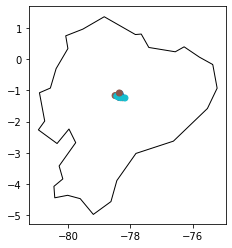

In [56]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
SA = world.query('name == "Ecuador"')
gdf4326 = gdf.to_crs(world.crs)

fig, ax = plt.subplots()
ax.set_aspect('equal')
SA.plot(ax=ax, color='white', edgecolor='black')
gdf4326.plot(ax=ax, column='tipo',figsize=(20,20))

plt.show()

#### Automate data extraction form Drive downloads

In [34]:
path = '/Users/tamarahuete/Documents/Github_repos/TFM21/data'
#ziplist = glob.glob(f'{path}/*.zip')
ziplist = glob.glob('data/*.zip')

In [96]:
zip = zipfile.ZipFile(f'{ziplist[0]}')
zip.namelist()[0:20]

['02-HGPT-MT-06.- Estacion Baños/2013-10-14/Banios_5min_20140116_subir.csv',
 '02-HGPT-MT-06.- Estacion Baños/2016-07-28/BANIOS_5MIN_20160728_subir.csv',
 '02-HGPT-MT-06.- Estacion Baños/2013-10-14/Banios_5min_20140116.csv',
 '02-HGPT-MT-06.- Estacion Baños/2015-02-06/8310_5min_20150211__.csv',
 '02-HGPT-MT-06.- Estacion Baños/2016-07-28/BANIOS_5MIN_20160728___.csv',
 '02-HGPT-MT-06.- Estacion Baños/2016-01-14/8310_5min_20160125_subir.csv',
 '02-HGPT-MT-06.- Estacion Baños/2013-06-13/8310_5min_20200203.csv',
 '02-HGPT-MT-06.- Estacion Baños/2016-01-14/8310_5min_20160125__.csv',
 '02-HGPT-MT-06.- Estacion Baños/2015-02-06/8310_5min_20150211_subir.csv',
 '02-HGPT-MT-06.- Estacion Baños/2013-10-14/Banios_5min_20140116.xls',
 '02-HGPT-MT-06.- Estacion Baños/2013-06-13/8310_1min_20170717.csv',
 '02-HGPT-MT-06.- Estacion Baños/2018-08-16/BANIOS_5MIN_20180816.csv',
 '02-HGPT-MT-06.- Estacion Baños/2015-02-06/8310_5min_20150211.csv',
 '02-HGPT-MT-06.- Estacion Baños/2013-10-14/83

In [107]:
#order ziplist by date
a = []
for i in range(len(zip.namelist())):
    date_str = zip.namelist()[i].split('/')[1]
    try:
        date_date = datetime.strptime(date_str, '%Y-%m-%d')
    except:
        print(f'{date_str} is not a date')
    a.append(date_date)

00_RESUMEN_1MIN_02 is not a date
00_RESUMEN_1MIN_02 is not a date
00_RESUMEN_1MIN_02 is not a date
00_RESUMEN_1MIN_02 is not a date
00_RESUMEN_1MIN_02 is not a date
00_RESUMEN_1MIN_02 is not a date
00_RESUMEN_1MIN_02 is not a date
00_RESUMEN_1MIN_02 is not a date
00_RESUMEN_1MIN_02 is not a date
00_RESUMEN_1MIN_02 is not a date
00_RESUMEN_1MIN_02 is not a date
00_RESUMEN_1MIN_02 is not a date
00_RESUMEN_1MIN_02 is not a date
00_RESUMEN_1MIN_02 is not a date
00_RESUMEN_1MIN_02 is not a date
00_RESUMEN_1MIN_02 is not a date
00_RESUMEN_1MIN_02 is not a date
00_RESUMEN_1MIN_02 is not a date
00_RESUMEN_1MIN_02 is not a date
00_RESUMEN_1MIN_02 is not a date
00_RESUMEN_1MIN_02 is not a date
00_RESUMEN_1MIN_02 is not a date


In [120]:
# get unique values
unique_dates = list(set(a))
# order by date
unique_dates.sort()
unique_dates
#convert back to string
str_dates = []
for l in range(len(unique_dates)):
    str_dates.append(unique_dates[l].strftime('%Y-%m-%d'))
str_dates

['2013-03-21',
 '2013-05-09',
 '2013-06-13',
 '2013-07-31',
 '2013-10-04',
 '2013-10-14',
 '2014-05-08',
 '2014-07-24',
 '2014-11-25',
 '2015-02-06',
 '2015-05-13',
 '2015-07-08',
 '2015-10-07',
 '2016-01-14',
 '2016-04-11',
 '2016-07-28',
 '2016-08-24',
 '2017-01-12',
 '2017-08-16',
 '2018-01-08',
 '2018-03-21',
 '2018-05-02',
 '2018-06-14',
 '2018-08-16',
 '2019-01-18',
 '2019-06-20',
 '2019-09-28',
 '2020-01-08']

In [119]:
# get files for each unique date


[datetime.datetime(2013, 3, 21, 0, 0),
 datetime.datetime(2013, 5, 9, 0, 0),
 datetime.datetime(2013, 6, 13, 0, 0),
 datetime.datetime(2013, 7, 31, 0, 0),
 datetime.datetime(2013, 10, 4, 0, 0),
 datetime.datetime(2013, 10, 14, 0, 0),
 datetime.datetime(2014, 5, 8, 0, 0),
 datetime.datetime(2014, 7, 24, 0, 0),
 datetime.datetime(2014, 11, 25, 0, 0),
 datetime.datetime(2015, 2, 6, 0, 0),
 datetime.datetime(2015, 5, 13, 0, 0),
 datetime.datetime(2015, 7, 8, 0, 0),
 datetime.datetime(2015, 10, 7, 0, 0),
 datetime.datetime(2016, 1, 14, 0, 0),
 datetime.datetime(2016, 4, 11, 0, 0),
 datetime.datetime(2016, 7, 28, 0, 0),
 datetime.datetime(2016, 8, 24, 0, 0),
 datetime.datetime(2017, 1, 12, 0, 0),
 datetime.datetime(2017, 8, 16, 0, 0),
 datetime.datetime(2018, 1, 8, 0, 0),
 datetime.datetime(2018, 3, 21, 0, 0),
 datetime.datetime(2018, 5, 2, 0, 0),
 datetime.datetime(2018, 6, 14, 0, 0),
 datetime.datetime(2018, 8, 16, 0, 0),
 datetime.datetime(2019, 1, 18, 0, 0),
 datetime.datetime(2019, 6, 2

In [55]:
zf = zipfile.ZipFile(f'{ziplist[0]}') 
df = pd.read_csv(zf.open(zip.namelist()[0]),sep = ';')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xf3 in position 11: invalid continuation byte

In [54]:
df.head()

,Fecha,Temperatura,T Max,T Min,Humedad,H_R Max,H_M Min,Precipitacion,Direccion,Velocidad
0,11/04/2016 9:35:00,"22,76","22,88","22,63","68,16","69,88","67,42",0,"105,06","2,2"
1,11/04/2016 9:40:00,"22,04","22,46","21,5","68,88","68,94","68,82",0,"130,55","1,77"
2,11/04/2016 9:45:00,"21,06","21,29","20,95","70,56","71,21","69,65",0,"131,3","1,86"
3,11/04/2016 9:50:00,"21,43","22,09","21,03","70,03","70,83","68,46",0,"111,11","2,11"
4,11/04/2016 9:55:00,"23,11","23,62","22,5","68,71","69,29","68,07",0,"103,2","1,96"


In [ ]:
### longitud and latitud formats
###